In [1]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.fftpack import dct, idct
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import sympy

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]

    def get_block(self, col, row):
        return self.img[col * 8 : (col + 1) * 8, row * 8 : (row + 1) * 8]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

MONO_DIR_PATH = "../../Mono/"
AIRPLANE = ImageLoader(MONO_DIR_PATH + "airplane512.bmp")
BARBARA = ImageLoader(MONO_DIR_PATH + "barbara512.bmp")
BOAT = ImageLoader(MONO_DIR_PATH + "boat512.bmp")
GOLDHILL = ImageLoader(MONO_DIR_PATH + "goldhill512.bmp")
LENNA = ImageLoader(MONO_DIR_PATH + "lenna512.bmp")
MANDRILL = ImageLoader(MONO_DIR_PATH + "mandrill512.bmp")
MILKDROP = ImageLoader(MONO_DIR_PATH + "milkdrop512.bmp")
SAILBOAT = ImageLoader(MONO_DIR_PATH + "sailboat512.bmp")

IMAGES = [
    AIRPLANE,
    BARBARA,
    BOAT,
    GOLDHILL,
    LENNA,
    MANDRILL,
    MILKDROP,
    SAILBOAT
]

In [2]:
class DMLCT:
    def __init__(self, n_bar, N):
        self.n_bar = n_bar
        self.N = N

        self.x_l = (2 * np.arange(N) + 1) / (2 * N)
        self.s_l = np.arange(n_bar) / (n_bar - 1)
        self.xi = (np.arange(n_bar + 1) - 0.5) / (n_bar - 1)

        self.lambda_kh = self.get_lambda_kh(self.n_bar)

        self.w_k_j = self.get_w_k_j(self.n_bar, self.N)
        self.W_L_k_kh = self.get_W_L_k_kh(self.n_bar, self.N)
        self.W_k_kh = self.get_W_k_kh(self.n_bar, self.N)
        self.W_R_k_kh = self.get_W_R_k_kh(self.n_bar, self.N)

    def Lagrange_j(self, j):
        x = sympy.Symbol("x")
        L_x = 1.0
        for l in range(self.n_bar):
            if l != j:
                L_x *= (x - self.s_l[l]) / (self.s_l[j] - self.s_l[l])
        return sympy.integrate(L_x)

    def get_lambda_kh(self, n_bar):
        lambda_kh = np.ones(n_bar)
        lambda_kh[0] = np.sqrt(1 / 2)
        return lambda_kh

    def get_w_k_j(self, n_bar, N):
        L_j = np.zeros((n_bar, N))
        x = sympy.Symbol("x")
        for j in range(n_bar):
            temp = []
            Lj = self.Lagrange_j(j)
            for k in range(N):
                temp.append(Lj.subs(x, self.x_l[k]))
            L_j[j] = np.array(temp)

        w_k_j = np.zeros((n_bar, N))
        for j in range(n_bar):
            w_k_j[j] = scipy.fftpack.dct(L_j[j], norm="ortho")
        return w_k_j

    def get_W_L_k_kh(self, n_bar, N):
        W_L_k_kh = np.zeros((n_bar - 1, N))
        lambda_kh = self.get_lambda_kh(n_bar)

        for kh in range(n_bar - 1):
            W_L_k_kh[kh] = (
                (1 - n_bar)
                * np.sqrt(2 / N)
                * lambda_kh[kh]
                * np.cos(np.pi * kh * (self.xi[0] + 1))
                * self.w_k_j[0]
            )
        return W_L_k_kh

    def get_W_k_kh(self, n_bar, N):
        W_k_kh = np.zeros((n_bar - 1, N))
        for kh in range(n_bar - 1):
            sum_sin = np.zeros(N)
            for j in range(1, n_bar - 2 + 1):
                sum_sin += np.sin(np.pi * kh * self.s_l[j]) * self.w_k_j[j]

            W_k_kh[kh] = (
                (n_bar - 1)
                * np.sqrt(2 / N)
                * self.lambda_kh[kh]
                * (
                    np.cos(np.pi * kh * self.xi[1])
                    * (self.w_k_j[0] - (-1) ** (kh) * self.w_k_j[n_bar - 1])
                    - 2 * np.sin((np.pi * kh) / (2 * (n_bar - 1))) * sum_sin
                )
            )
        return W_k_kh

    def get_W_R_k_kh(self, n_bar, N):
        W_R_k_kh = np.zeros((n_bar - 1, N))
        for kh in range(n_bar - 1):
            W_R_k_kh[kh] = (
                (n_bar - 1)
                * np.sqrt(2 / N)
                * self.lambda_kh[kh]
                * np.cos(np.pi * kh * (self.xi[n_bar] - 1))
                * self.w_k_j[n_bar - 1]
            )
        return W_R_k_kh

In [3]:
def get_F_L_k_horizontal(arr, N, row, col):
    # w
    if col == 0:
        w_block = np.zeros(N)
    else:
        w_block = arr[row, (col - 1) * N : col * N]

    return w_block

In [4]:
def get_F_R_k_horizontal(arr, N, row, col):
    # e
    if col == arr.shape[1] // N - 1:
        e_block = np.zeros(N)
    else:
        e_block = arr[row, (col + 1) * N : (col + 2) * N]

    return e_block

In [5]:
def get_F_L_k_vertical(arr, N, row, col):
    # n
    if row == 0:
        n_block = np.zeros(N)
    else:
        n_block = arr[(row - 1) * N : row * N, col]

    return n_block

In [6]:
def get_F_R_k_vertical(arr, N, row, col):
    # s
    if row == arr.shape[0] // N - 1:
        s_block = np.zeros(N)
    else:
        s_block = arr[(row + 1) * N : (row + 2) * N, col]

    return s_block

In [84]:
n_bar = 2
N = 8

In [85]:
dmlct = DMLCT(n_bar, N)

In [86]:
IMG = LENNA

In [87]:
Fk = np.zeros(IMG.img.shape)

# 順変換

In [88]:
def DMLCT_forward(IMG,n_bar,N):
    Fk = np.zeros(IMG.img.shape)
    
    ## 縦方向
    ### DCT
    for row in range(IMG.img.shape[0] // N):
        for col in range(IMG.img.shape[1]):
            eight_points = IMG.img[N * row : N * (row + 1), col]
            c = scipy.fftpack.dct(eight_points, norm="ortho")
            Fk[N * row : N * (row + 1), col] = c
    ### 残差
    dmlct = DMLCT(n_bar,N)
    for row in range(IMG.img.shape[0] // N):
        for col in range(IMG.img.shape[1]):
            # ビューなら直接いじっちゃう
            F = Fk[N * row : N * (row + 1), col]
            F_L = get_F_L_k_vertical(Fk, N, row, col)
            F_R = get_F_R_k_vertical(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)
            for kh in range(n_bar - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
            F[n_bar - 2 + 1 :] -= U_k_n_bar[n_bar - 2 + 1 :]
    # 0を残す
    for k in reversed(range(1, n_bar - 2 + 1)):
        dmlct = DMLCT(k+1, N)
        for row in range(IMG.img.shape[0] // N):
            for col in range(IMG.img.shape[1]):
                # ビューなら直接いじっちゃう
                F = Fk[N * row : N * (row + 1), col]
                F_L = get_F_L_k_vertical(Fk, N, row, col)
                F_R = get_F_R_k_vertical(Fk, N, row, col)

                U_k_n_bar = np.zeros(N)

                for kh in range((k + 1) - 2 + 1):
                    U_k_n_bar += (
                        F_L[kh] * dmlct.W_L_k_kh[kh]
                        + F[kh] * dmlct.W_k_kh[kh]
                        + F_R[kh] * dmlct.W_R_k_kh[kh]
                    )

                F[k] -= U_k_n_bar[k]
    ## 横方向
    ### DCT
    for row in range(Fk.shape[0]):
        for col in range(Fk.shape[1] // N):
            eight_points = Fk[row, N * col : N * (col + 1)]
            c = scipy.fftpack.dct(eight_points, norm="ortho")
            Fk[row, N * col : N * (col + 1)] = c
            
    ### 残差
    dmlct = DMLCT(n_bar,N)
    for row in range(IMG.img.shape[0]):
        for col in range(IMG.img.shape[1] // N):
            F = Fk[row, N * col : N * (col + 1)]
            F_L = get_F_L_k_horizontal(Fk, N, row, col)
            F_R = get_F_R_k_horizontal(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)
            for kh in range(n_bar - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
            F[n_bar - 2 + 1 :] -= U_k_n_bar[n_bar - 2 + 1 :]
    # 0を残す
    for k in reversed(range(1, n_bar - 2 + 1)):
        dmlct = DMLCT(k+1, N)
        for row in range(IMG.img.shape[0]):
            for col in range(IMG.img.shape[1] // N):
                F = Fk[row, N * col : N * (col + 1)]
                F_L = get_F_L_k_horizontal(Fk, N, row, col)
                F_R = get_F_R_k_horizontal(Fk, N, row, col)

                U_k_n_bar = np.zeros(N)

                for kh in range((k + 1) - 2 + 1):
                    U_k_n_bar += (
                        F_L[kh] * dmlct.W_L_k_kh[kh]
                        + F[kh] * dmlct.W_k_kh[kh]
                        + F_R[kh] * dmlct.W_R_k_kh[kh]
                    )

                F[k] -= U_k_n_bar[k]
    
    return Fk

In [89]:
Fk_values = np.zeros((25,4))

In [90]:
values = np.zeros((25,4))
Fk = np.zeros(IMG.img.shape)
for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1] // N):
        block = IMG.img[row * N : (row + 1) * N, col * N : (col + 1) * N]
        c = scipy.fftpack.dct(
            scipy.fftpack.dct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
        )
        Fk[row * N : (row + 1) * N, col * N : (col + 1) * N] = c

for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1] // N):
        if col == 0:
            continue
        if col == IMG.img.shape[1] // N -1:
            continue
        if row == 0:
            continue
        if row == IMG.img.shape[0] // N -1:
            continue
        block = Fk[row * N : (row + 1) * N, col * N : (col + 1) * N]
        values[0,5-n_bar] += np.abs(block[0,1])
        values[1,5-n_bar] += np.abs(block[1,0])
        values[2,5-n_bar] += np.abs(block[1,1])
        values[3,5-n_bar] += np.abs(block[0,2])
        values[4,5-n_bar] += np.abs(block[2,0])
        values[5,5-n_bar] += np.abs(block[1,2])
        values[6,5-n_bar] += np.abs(block[2,1])
        values[7,5-n_bar] += np.abs(block[2,2])
        values[8,5-n_bar] += np.abs(block[0,3])
        values[9,5-n_bar] += np.abs(block[3,0])
        values[10,5-n_bar] += np.abs(block[1,3])
        values[11,5-n_bar] += np.abs(block[3,1])
        values[12,5-n_bar] += np.abs(block[2,3])
        values[13,5-n_bar] += np.abs(block[3,2])
        values[14,5-n_bar] += np.abs(block[3,3])
        values[15,5-n_bar] += np.abs(block[0,4])
        values[16,5-n_bar] += np.abs(block[4,0])
        values[17,5-n_bar] += np.abs(block[1,4])
        values[18,5-n_bar] += np.abs(block[4,1])
        values[19,5-n_bar] += np.abs(block[2,4])
        values[20,5-n_bar] += np.abs(block[4,2])
        values[21,5-n_bar] += np.abs(block[3,4])
        values[22,5-n_bar] += np.abs(block[4,3])
        values[23,5-n_bar] += np.abs(block[4,4])
        values[24,5-n_bar] = 0
        for i in range(N):
            for j in range(N):
                if i > 4 or j > 4:
                    values[24,5-n_bar] += block[i,j]
                    
Fk_values[:,5-n_bar] += values[:,5-n_bar]/ ((IMG.img.shape[0]//N)**2) 

In [91]:
# Fk_values /= len(IMAGES)

In [92]:
Vk_values = np.zeros((25,4))

In [93]:
values = np.zeros((25,4))
Fk = DMLCT_forward(IMG,n_bar,N)
for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1] // N):
        block = Fk[row * N : (row + 1) * N, col * N : (col + 1) * N]
        values[0,5-n_bar] += np.abs(block[0,1])
        values[1,5-n_bar] += np.abs(block[1,0])
        values[2,5-n_bar] += np.abs(block[1,1])
        values[3,5-n_bar] += np.abs(block[0,2])
        values[4,5-n_bar] += np.abs(block[2,0])
        values[5,5-n_bar] += np.abs(block[1,2])
        values[6,5-n_bar] += np.abs(block[2,1])
        values[7,5-n_bar] += np.abs(block[2,2])
        values[8,5-n_bar] += np.abs(block[0,3])
        values[9,5-n_bar] += np.abs(block[3,0])
        values[10,5-n_bar] += np.abs(block[1,3])
        values[11,5-n_bar] += np.abs(block[3,1])
        values[12,5-n_bar] += np.abs(block[2,3])
        values[13,5-n_bar] += np.abs(block[3,2])
        values[14,5-n_bar] += np.abs(block[3,3])
        values[15,5-n_bar] += np.abs(block[0,4])
        values[16,5-n_bar] += np.abs(block[4,0])
        values[17,5-n_bar] += np.abs(block[1,4])
        values[18,5-n_bar] += np.abs(block[4,1])
        values[19,5-n_bar] += np.abs(block[2,4])
        values[20,5-n_bar] += np.abs(block[4,2])
        values[21,5-n_bar] += np.abs(block[3,4])
        values[22,5-n_bar] += np.abs(block[4,3])
        values[23,5-n_bar] += np.abs(block[4,4])
        values[24,5-n_bar] = 0
        for i in range(N):
            for j in range(N):
                if i > 4 or j > 4:
                    values[24,5-n_bar] += block[i,j]

Vk_values[:,5-n_bar] += values[:,5-n_bar] / ((IMG.img.shape[0]//N)**2)              

In [94]:
# Vk_values /= len(IMAGES)

In [95]:
G_values[:,5-n_bar] = 100 * (1 - Vk_values[:,5-n_bar]/Fk_values[:,5-n_bar])

In [96]:
columns = ["n=5","n=4","n=3","n=2"]
index = ["(0,1)","(1,0)","(1,1)",
        "(0,2)","(2,0)","(1,2)","(2,1)","(2,2)",
        "(0,3)","(3,0)","(1,3)","(3,1)","(2,3)","(3,2)","(3,3)",
        "(0,4)","(4,0)","(1,4)","(4,1)","(2,4)","(4,2)","(3,4)","(4,3)","(4,4)",
        "others"]
df = pd.DataFrame(G_values,columns=columns,index=index)
print(df)
df.to_csv("DMLCT_high_freq_comp.csv",header=False,index=False)

              n=5        n=4        n=3         n=2
(0,1)   18.056583  18.056583  18.056583   18.056583
(1,0)   14.239904  14.239904  14.239904   14.239904
(1,1)   10.685372  10.685372  10.685372   10.685372
(0,2)   11.123094  11.123094  11.123094    5.413372
(2,0)    0.978251   0.978251   0.978251    0.764902
(1,2)   12.657094  12.657094  12.657094    7.253010
(2,1)   12.628600  12.628600  12.628600    3.993591
(2,2)   12.795872  12.795872  12.795872    4.695693
(0,3)    4.456994   4.456994   4.157369    2.402851
(3,0)   -6.496432  -6.496432  -3.252362   -1.546533
(1,3)    7.548136   7.548136   4.572952    1.197429
(3,1)    6.527561   6.527561   1.951049   -2.546664
(2,3)    7.392737   7.392737   5.433172   -0.134822
(3,2)    5.712842   5.712842   2.154595   -1.595256
(3,3)    4.282382   4.282382   1.028602   -2.567206
(0,4)   -0.351915  -0.193932   0.609574   -0.302506
(4,0)  -10.761281  -8.049803  -5.633966   -3.142960
(1,4)    4.225091   2.541579   2.422163   -0.061918
(4,1)    3.8

In [55]:
G_values = np.zeros((25,4))

# 係数の確保

In [18]:
Fk_Ori = np.copy(Fk)

# 逆変換

In [19]:
recover = np.zeros(IMG.img.shape)

## 横方向

### 残差

In [20]:
for k in range(1, n_bar - 2 + 1):
    for row in range(IMG.img.shape[0]):
        for col in range(IMG.img.shape[1] // N):
            F = Fk[row, N * col : N * (col + 1)]
            F_L = get_F_L_k_horizontal(Fk, N, row, col)
            F_R = get_F_R_k_horizontal(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)
            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] += U_k_n_bar[k]

In [21]:
for row in range(IMG.img.shape[0]):
    for col in range(IMG.img.shape[1] // N):
        F = Fk[row, N * col : N * (col + 1)]
        F_L = get_F_L_k_horizontal(Fk, N, row, col)
        F_R = get_F_R_k_horizontal(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] += U_k_n_bar[n_bar - 2 + 1 :]

### IDCT

In [22]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // N):
        F = Fk[row, N * col : N * col + N]
        data = scipy.fftpack.idct(F, norm="ortho")
        # Fkに代入した後、縦方向に対して処理
        Fk[row, N * col : N * col + N] = data

## 縦方向

### 残差

In [23]:
for k in range(1, n_bar - 2 + 1):
    for row in range(IMG.img.shape[0] // N):
        for col in range(IMG.img.shape[1]):
            # ビューなら直接いじっちゃう
            F = Fk[N * row : N * (row + 1), col]
            F_L = get_F_L_k_vertical(Fk, N, row, col)
            F_R = get_F_R_k_vertical(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)

            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] += U_k_n_bar[k]

In [24]:
for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1]):
        # ビューなら直接いじっちゃう
        F = Fk[N * row : N * (row + 1), col]
        F_L = get_F_L_k_vertical(Fk, N, row, col)
        F_R = get_F_R_k_vertical(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] += U_k_n_bar[n_bar - 2 + 1 :]

### IDCT

In [25]:
for row in range(Fk.shape[0] // N):
    for col in range(Fk.shape[1]):
        F = Fk[N * row : N * (row + 1), col]
        data = scipy.fftpack.idct(F, norm="ortho")
        # 復元画像
        recover[N * row : N * (row + 1), col] = data

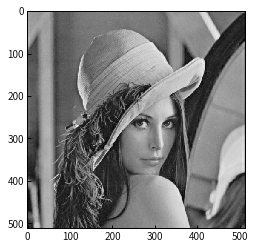

In [29]:
plt.imshow(recover.astype("u8"), cmap="gray")

もどった...！